# Simulation for Penalized Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [2]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt

In [3]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
    # if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [4]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)
        
bell_dict = {}

0
100
200
300
400
500
600
700
800
900
1000


## Main Implementation

In [65]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites, param_name, curr_params):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites, param_name, curr_params)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def brute_force_sample (cluster_constraints, cls, uf, config):
    '''Randomly sample a color for each cluster'''
    max_col = None
    for cluster in uf.components():
        for site_str in cluster:
            site = str2site(site_str)
            max_col = cluster_constraints[cls[site[0],site[1]]]
            cluster_color = np.random.choice((np.arange(1, max_col+1)))
            break
        for site_str in cluster:
            site = str2site(site_str)
            config[site[0],site[1]] = cluster_color
    if prt: print("done sampling cluster colors")
    
    return config


def sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf=None, cluster_constraints=None):
    
    if uf==None and not only_averages:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.uint16) # up to 255x255 box
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
            cluster_constraints[cl_n] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field and gamma > 0
    if (curr_params['alpha']==0 and curr_params['gamma']>0):
        if prt: print('Case with no field and gamma > 0')
            
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if only_averages:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if only_averages:
            '''Only compute average in case with zero field and no interaction, but with gamma > 0,
               use an arbitray partition (avoid computing Bell polynomials)
            '''
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k blocks using Bell polynomials'''
        partition_dict = {}
        if ((no_cl,exact_k) in bell_dict):
            partition_dict = bell_dict[(no_cl,exact_k)]
            if prt: print ("Bell found", (no_cl,exact_k))
        else:
            session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
            partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs], subs]")
            bell_dict[(no_cl,exact_k)] = partition_dict
            if prt: print ("Bell computed", (no_cl,exact_k))
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for root in cluster_constraints:
            cluster_color = color_arr[i]
            for site_str in uf.component(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field and gamma > 0 or case with gamma = 0
    else:
        '''Randomly sample a color for each cluster'''
        if prt: print('Case with field and gamma > 0 or case with gamma = 0')
        config = brute_force_sample (cluster_constraints, cls, uf, config)
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites, param_name, curr_params):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force until compatible with eta_lambda
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [81]:
def single_experiment (N, no_cols, gamma=0, J=0, alpha=0, iters=100):
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    param_name = "Alpha"

    '''Probabilities ordered from highest (high energy) to lowest'''
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    print('lambda probabilities:', lambda_prob)

    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)

    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)

    eta_prob = (lambda_prob, edge_prob, site_prob)

    '''Current states of eta'''
    eta_lambda = 0
    eta_edges = np.zeros((N,N,2), dtype=np.int8)
    # Special edge cases (no neighbors at the border)
    eta_edges[:,N-1,1] = -1
    eta_edges[N-1,:,0] = -1
    eta_sites = np.zeros((N,N), dtype=np.int8)
    eta = [eta_lambda, eta_edges, eta_sites]

    '''List of sites (tuples) for Union-Find'''
    sites = []
    for i in range(N):
        for j in range(N):
            sites.append(str(i)+','+str(j))

    config = initial_config(N, no_cols)
    print('\ninitial config:')
    print(config)
    for i in range(iters):
        if i%10 == 0:
            print('\n' + '-'*50 + ' iter ' + str(i) + ' ' + '-'*50)
            plt.imshow(config)
            plt.show()
        config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)

    print('\nfinal config:')
    print(config)
    plt.imshow(config)
    plt.show()

    session.terminate()

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.32967995 0.67032005]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 3 10  8 ...  6  6  5]
 [ 1 10  2 ...  5  3  5]
 [ 5  5  6 ...  3  3  1]
 ...
 [ 2  2  7 ...  5  5  2]
 [ 2  4  4 ...  5  4  3]
 [10  5  4 ...  4  1  7]]

-------------------- iter 0 --------------------

-------------------- iter 20 --------------------

-------------------- iter 40 --------------------

-------------------- iter 60 --------------------

-------------------- iter 80 --------------------

final config:
[[ 6  3  2 ...  4  9  8]
 [ 4  3  5 ...  6  1  4]
 [ 8  7  4 ...  5  8 10]
 ...
 [ 6  1  3 ...  5  3  7]
 [ 2  4  2 ...  8  1  7]
 [ 9  3  2 ...  9  9  2]]


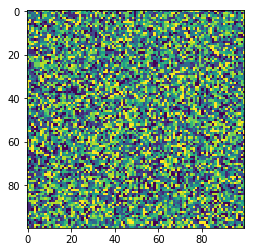

In [63]:
only_averages = False
prt = False
N, no_cols = 100, 10
gamma = 0    # strength of preference for low no. of cols
J = .2        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.63212056 0.36787944]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 3  3  5 ...  7  4  5]
 [10  4  7 ...  2  1  3]
 [ 2  7 10 ...  1  5  1]
 ...
 [ 4  8  3 ...  9  1  4]
 [ 2  6 10 ...  1  1  5]
 [ 3  5  7 ...  3  7  4]]

-------------------- iter 0 --------------------

-------------------- iter 20 --------------------

-------------------- iter 40 --------------------

-------------------- iter 60 --------------------

-------------------- iter 80 --------------------

final config:
[[ 3  4  1 ...  1  7  8]
 [ 3  5  7 ... 10 10  4]
 [ 2  3  7 ...  6  8  6]
 ...
 [ 6  3  2 ...  3  5  4]
 [ 3 10  2 ...  6  6  1]
 [ 2  6  6 ...  6 10 10]]


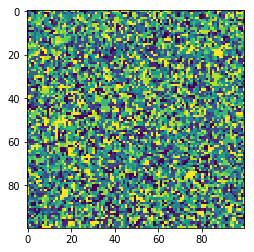

In [56]:
only_averages = False
prt = False
N, no_cols = 100, 10
gamma = 0    # strength of preference for low no. of cols
J = .5        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.75340304 0.24659696]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 7 10  2 ...  2  3 10]
 [ 8  9  1 ...  2 10 10]
 [ 9  3  3 ...  4 10  5]
 ...
 [ 9  1  2 ...  6  2  6]
 [ 8  2  5 ...  2  1  3]
 [10  5 10 ...  5  5  9]]

-------------------- iter 0 --------------------

-------------------- iter 20 --------------------

-------------------- iter 40 --------------------

-------------------- iter 60 --------------------

-------------------- iter 80 --------------------

final config:
[[5 1 1 ... 1 1 1]
 [1 1 1 ... 7 8 1]
 [9 9 4 ... 8 8 1]
 ...
 [8 8 3 ... 2 5 5]
 [2 2 7 ... 2 5 5]
 [9 7 7 ... 9 5 5]]


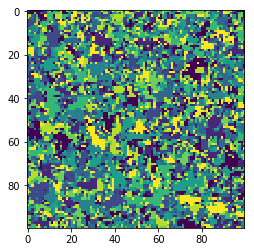

In [58]:
only_averages = False
prt = False
N, no_cols = 100, 10
gamma = 0    # strength of preference for low no. of cols
J = .7        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.77686984 0.22313016]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 2 10  3 ...  2  5  9]
 [ 6  4  8 ...  9  3  7]
 [ 1 10  5 ...  4  9  3]
 ...
 [ 4  6  7 ...  4  5  4]
 [ 4  2  5 ... 10  2  3]
 [ 3  5  2 ...  1 10  5]]

-------------------- iter 0 --------------------

-------------------- iter 20 --------------------

-------------------- iter 40 --------------------

-------------------- iter 60 --------------------

-------------------- iter 80 --------------------

final config:
[[ 6  8  8 ...  2  2  9]
 [10  5  9 ...  7  2  2]
 [10  3 10 ...  7  9  1]
 ...
 [ 3  7  4 ...  3  4  2]
 [ 3  5 10 ...  8  8  7]
 [ 3  6  4 ...  8  8  7]]


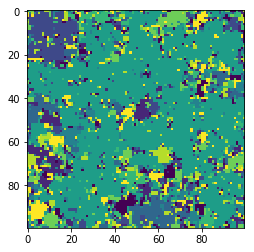

In [62]:
only_averages = False
prt = False
N, no_cols = 100, 10
gamma = 0    # strength of preference for low no. of cols
J = .75        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.79810348 0.20189652]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 6  5  9 ...  9  3  9]
 [ 1  8  2 ...  4  3  4]
 [ 9  3  2 ...  6  1  8]
 ...
 [ 2  1  5 ...  9  2 10]
 [ 3  6  2 ...  4  8  3]
 [ 1  8  1 ...  9  6  5]]

-------------------- iter 0 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  1  1 ...  1  0  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 ...
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):

done sampling cluster colors
config:
[[ 7  8  1 ...  1  7  7]
 [ 8  5  5 ...  3  1  8]
 [ 8  5  5 ...  3  6  6]
 ...
 [ 8  9  4 ...  7  3  3]
 [ 1  5  4 ...  7  8  9]
 [ 5  5 10 ...  8  6  7]]

-------------------- iter 6 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  1  1]
 [ 1  1  1 ...  0  1  0]
 ...
 [ 1  1  0 ...  0  1  1]
 [ 1  0  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  0 -1]
 [ 1  0  1 ...  1  1 -1]
 [ 1  0  1 ...  1  0 -1]
 ...
 [ 1  1  1 ...  1  0 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]

current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  1  1 ...  1  0  1]
 [ 1  1  1 ...  0  1  1]
 [ 1  0  1 ...  0  1  1]
 ...
 [ 1  0  1 ...  0  0  1]
 [ 1  0  1 ...  1  0  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 1  0  0 ...  1  1 -1]
 [ 0  1  1 ...  1  1 -1]
 ...
 [ 1  0  1 ...  0  1 -1]
 [ 1  1  1 ...  0  0 -1]
 [ 0  0  1 ...  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    3 ...   95   96   97]
 [  98   99   99 ...  172   96  175]
 [ 176  176  178 ...  172  258  259]
 ...
 [1200 1201 1201 ... 1132 1132 1280]
 [1281 1201 1282 ... 1132 1132 1132]
 [1201 1201 1201 ... 1446 1132 1132]]
Case with field and gamma

assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    1    2 ...   86   87   87]
 [  89   90   89 ...  155   87   87]
 [  89   89   89 ...  154  217   87]
 ...
 [ 764 1050 1051 ...  760  760 1105]
 [1109 1109 1110 ...  760  760 1170]
 [1171 1172 1172 ...  760 1170 1170]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[10 10  8 ...  2  3  3]
 [ 4 10  4 ...  1  3  3]
 [ 4  4  4 ...  3  2  3]
 ...
 [ 9  1  6 ...  6  6  5]
 [ 5  5  1 ...  6  6  7]
 [ 2  8  8 ...  6  7  7]]

-------------------- iter 19 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  1  1 ...  1  0  0]
 [ 0  1 

clusters formed by bonds (eta_edge):
[[   1    1    3 ...   89   90   90]
 [  92   93    5 ...   90   90   90]
 [  92   92    5 ...  206  208  209]
 ...
 [ 936  937  937 ...  758  758  758]
 [ 996  996  999 ...  758  758  758]
 [1046  996 1045 ...  758  758  758]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 9  9  9 ...  3  1  1]
 [ 8  8  9 ...  1  1  1]
 [ 8  8  9 ... 10  1  9]
 ...
 [ 7  6  6 ...  4  4  4]
 [ 8  8  2 ...  4  4  4]
 [10  8  8 ...  4  4  4]]

-------------------- iter 25 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  1  0 ...  1  0  1]
 [ 0  0  0 ...  1  0  1]
 [ 0  0  0 ...  1  1  1]
 ...
 [ 1  1  1 ...  1  0  0]
 [ 1  0  1 ...  0  1  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 0  0  0 ...  1  0 -1]
 [ 0  1  0 ...  0  0 -1]
 [ 0  1  0 ... 

assigned bonds (eta_edges):
[[ 1  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  0  1]
 [ 1  1  0 ...  1  1  1]
 ...
 [ 1  0  1 ...  1  0  0]
 [ 0  1  0 ...  0  1  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 0  0  1 ...  1  0 -1]
 [ 1  0  0 ...  1  1 -1]
 [ 0  1  1 ...  1  1 -1]
 ...
 [ 1  1  1 ...  1  0 -1]
 [ 1  1  0 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[  1   1   1 ...  70  71  71]
 [ 73   3   3 ...  65 118 119]
 [ 73  73   3 ...  65 118 163]
 ...
 [820 821 822 ... 494 819 819]
 [883 821 884 ... 494 819 819]
 [883 943 884 ... 494 993 819]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 1  1  1 ...  5 10 10]
 [10  8  8 ...  9  6  8]
 [10 10  8 ...  9  6  3]
 ...
 [ 8 

assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[  1   2   2 ...  71  73  70]
 [ 75  75   5 ...  70  70  70]
 [ 75  75   5 ...  70  70  70]
 ...
 [732 733 734 ... 473 473 473]
 [784 787 734 ... 473 473 473]
 [831 831 734 ... 882 883 884]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[8 2 2 ... 6 6 2]
 [8 8 7 ... 2 2 2]
 [8 8 7 ... 2 2 2]
 ...
 [8 9 5 ... 4 4 4]
 [8 5 5 ... 4 4 4]
 [6 6 5 ... 6 9 9]]

-------------------- iter 38 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 0  1  1 ...  1  1  0]
 [ 0  0  1 ...  0  1  1]
 [ 0  0  0 ...  0  1  0]
 ...
 [ 0  1  0 ...  1  0  0]


probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  1  1 ...  1  0  1]
 [ 0  1  0 ...  1  1  1]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 1  0  1 ...  1  1  1]
 [ 1  1  1 ...  0  0  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  0  1 ...  1  1 -1]
 [ 0  0  0 ...  0  1 -1]
 [ 0  1  0 ...  1  0 -1]
 ...
 [ 0  1  0 ...  0  1 -1]
 [ 1  0  1 ...  0  1 -1]
 [ 1  1  0 ...  0  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[  1   2   2 ...  63  66  67]
 [ 68  68  68 ...  66  66 125]
 [ 68  68  68 ... 122 175 175]
 ...
 [532 532 637 ... 634 634 678]
 [679 532 532 ... 634 634 727]
 [728 730 731 ... 634 634 761]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 6  4  4 ...  2  5  8]
 [10 10 10 

assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[  1   2   2 ...  71  73  74]
 [  2   2   2 ... 115 116 117]
 [  2   2   2 ... 115 159 159]
 ...
 [491 491 491 ... 630 630 599]
 [632 633 523 ... 630 630 667]
 [668 669 670 ... 630 630 667]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[2 3 3 ... 8 3 3]
 [3 3 3 ... 4 6 2]
 [3 3 3 ... 4 5 5]
 ...
 [1 1 1 ... 5 5 2]
 [9 5 4 ... 5 5 5]
 [7 4 4 ... 5 5 5]]

-------------------- iter 51 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  0  0 ...  1  1  1]
 [ 0  0  0 ...  0  1  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 1  1  1 ...  0  0  1]


assigned bonds (eta_edges):
[[ 1  1  0 ...  0  0  1]
 [ 0  0  0 ...  0  0  1]
 [ 1  1  1 ...  1  0  0]
 ...
 [ 1  1  1 ...  0  1  1]
 [ 1  1  1 ...  0  0  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  0 ...  1  1 -1]
 [ 0  0  1 ...  0  1 -1]
 [ 0  0  0 ...  0  0 -1]
 ...
 [ 1  1  1 ...  0  1 -1]
 [ 0  1  1 ...  0  0 -1]
 [ 1  1  1 ...  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[  1   2   3 ...  54  54  60]
 [  3   3   3 ...  54  54  96]
 [  3   3   3 ...  54  54  54]
 ...
 [511 512 489 ... 509 509 535]
 [536 536 537 ... 509 509 509]
 [573 574 575 ... 509 509 509]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 8  6  5 ...  8  8  5]
 [ 5  5  5 ...  8  8  4]
 [ 5  5  5 ...  8  8  8]
 ...
 [ 7 

assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    2 ...   83   84   85]
 [  86    2    2 ...  150  150  153]
 [ 154  155    2 ...  150  150  150]
 ...
 [   7    7    7 ...  985 1040  986]
 [   7    7    7 ...  985  985 1112]
 [1113    7 1114 ...  985  985 1185]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 7  8  8 ...  2  8  7]
 [ 6  8  8 ...  7  7  9]
 [ 9  4  8 ...  7  7  7]
 ...
 [ 5  5  5 ...  2  4 10]
 [ 5  5  5 ...  2  2  7]
 [10  5  2 ...  2  2  6]]

-------------------- iter 64 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  0  0 ...  1  1  1]
 [ 1  1 

clusters formed by bonds (eta_edge):
[[   1    3    3 ...   75   76   77]
 [  78    3    3 ...   75  139   77]
 [ 141  142  143 ...   75  139  207]
 ...
 [ 862  101  101 ...  101  955  956]
 [ 957  101  101 ...  101  101 1021]
 [1022 1023 1023 ...  101  101 1021]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 3  2  2 ...  6  2  1]
 [10  2  2 ...  6  3  1]
 [10 10  1 ...  6  3 10]
 ...
 [ 2  6  6 ...  6  1  9]
 [ 9  6  6 ...  6  6 10]
 [ 8  7  7 ...  6  6 10]]

-------------------- iter 70 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  0  0 ...  0  1  0]
 [ 1  1  1 ...  0  0  1]
 [ 0  0  1 ...  1  1  0]
 ...
 [ 1  0  0 ...  0  1  1]
 [ 1  1  1 ...  0  0  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  0  0 ...  1  1 -1]
 [ 1  0  0 ...  1  1 -1]
 [ 0  1  1 ... 

probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  1  0 ...  0  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 0  0  0 ...  1  1  1]
 ...
 [ 1  1  0 ...  0  0  0]
 [ 1  0  0 ...  0  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 0  1  1 ...  1  0 -1]
 [ 1  0  1 ...  1  1 -1]
 ...
 [ 1  1  0 ...  1  1 -1]
 [ 1  0  0 ...  0  1 -1]
 [ 1  0  0 ...  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[  1   2   3 ...  75  78  79]
 [ 80  80   3 ...  75 131 131]
 [133 134 134 ... 189 190 191]
 ...
 [739 740  99 ... 833 833 699]
 [782  99  99 ... 833 833 699]
 [834  99  99 ... 833 892 893]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 2 10 10 ...  9  7  6]
 [ 5  5 10 

assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[  1   2   2 ...  70  70  72]
 [  2   2  75 ... 119 120  72]
 [ 23  23  23 ... 119 170 170]
 ...
 [632 633  23 ... 672 672 675]
 [676  23  23 ... 672 672 725]
 [726  23  23 ... 672 768 725]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 3  6  6 ...  8  8  6]
 [ 6  6  4 ... 10  2  6]
 [ 7  7  7 ... 10  3  3]
 ...
 [10  7  7 ...  2  2  3]
 [ 6  7  7 ...  2  2  8]
 [ 7  7  7 ...  2  6  8]]

-------------------- iter 83 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 1  0  1 ...  1  1  0]
 [ 1  1  1 ...  0  1  1]
 [ 0  0  0 ...  1  

assigned bonds (eta_edges):
[[ 1  0  1 ...  1  0  1]
 [ 1  1  1 ...  1  0  0]
 [ 1  0  0 ...  1  0  0]
 ...
 [ 0  0  1 ...  1  1  1]
 [ 1  1  0 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  0  1 ...  1  1 -1]
 [ 1  1  1 ...  1  0 -1]
 [ 1  1  0 ...  1  0 -1]
 ...
 [ 1  0  1 ...  0  1 -1]
 [ 1  0  0 ...  1  0 -1]
 [ 1  0  1 ...  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[  1   2   2 ...  49  36  51]
 [ 52   2  54 ...  96  36  36]
 [ 98  36  36 ... 135  36  36]
 ...
 [507  36  36 ...  36  36 538]
 [507  36  36 ... 575 576 576]
 [577  36  36 ... 621 622 623]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 1  3  3 ...  4  8 10]
 [ 1  3 10 ...  6  8  8]
 [ 6  8  8 ...  1  8  8]
 ...
 [ 2 

assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[  1   2   2 ...  61  16  16]
 [  1   2  65 ... 108  16  16]
 [109 109 111 ...  16  16  16]
 ...
 [439  16  16 ...  16 470 471]
 [439  16  16 ...  16 471 471]
 [513  16  16 ... 551 552 552]]
Case with field and gamma > 0 or case with gamma = 0
done sampling cluster colors
config:
[[ 1  1  1 ...  2  3  3]
 [ 1  1 10 ... 10  3  3]
 [ 1  1  1 ...  3  3  3]
 ...
 [10  3  3 ...  3  5  3]
 [10  3  3 ...  3  3  3]
 [ 2  3  3 ...  4 10 10]]

-------------------- iter 96 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.79810348 0.20189652]
assigned bonds (eta_edges):
[[ 0  0  1 ...  1  1  0]
 [ 1  1  1 ...  1  0  0]
 [ 1  1  1 ...  1  

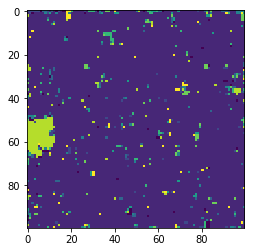

In [52]:
only_averages = False
prt = True
N, no_cols = 100, 10
gamma = 0    # strength of preference for low no. of cols
J = .8        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.83470111 0.16529889]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 3  8  2 ... 10  8  5]
 [ 4  4  4 ...  7  1  7]
 [ 2 10  1 ...  3  3  9]
 ...
 [ 2  1  5 ...  9  5  8]
 [ 9  7  6 ... 10 10 10]
 [ 3  4  9 ...  9  2  3]]

-------------------- iter 0 --------------------

-------------------- iter 20 --------------------

-------------------- iter 40 --------------------

-------------------- iter 60 --------------------

-------------------- iter 80 --------------------

final config:
[[8 8 8 ... 9 7 9]
 [8 8 8 ... 8 7 7]
 [8 8 8 ... 8 7 7]
 ...
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 4 8]]


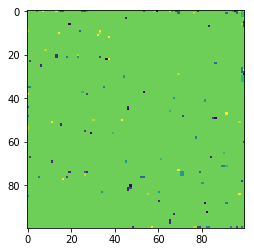

In [60]:
only_averages = False
prt = False
N, no_cols = 100, 10
gamma = 0    # strength of preference for low no. of cols
J = .9        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.75340304 0.24659696]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[10  2  7 ... 12 12  9]
 [15 13  6 ...  2 10 15]
 [14  8 13 ...  5  1  3]
 ...
 [ 2 13 15 ...  3 11  3]
 [15 15 13 ...  5  3 15]
 [ 2 12  5 ...  2  2 10]]

-------------------- iter 0 --------------------

-------------------- iter 20 --------------------

-------------------- iter 40 --------------------

-------------------- iter 60 --------------------

-------------------- iter 80 --------------------

final config:
[[ 4 12  2 ...  2  8 13]
 [ 4 14 13 ... 15  5 13]
 [15 10 10 ... 10  4 13]
 ...
 [ 3  3 13 ... 13  1  1]
 [10  9  6 ... 16  1 13]
 [ 9 11  6 ... 15 16 16]]


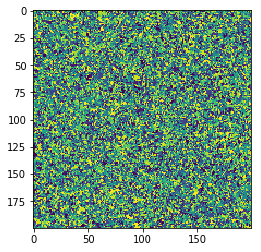

In [69]:
only_averages = False
prt = False
N, no_cols = 200, 16
gamma = 0    # strength of preference for low no. of cols
J = .7        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.79810348 0.20189652]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 5  4  5 ... 15  7 10]
 [ 8  5 13 ... 10  6 16]
 [ 8  4 13 ... 10  6  1]
 ...
 [ 5 15  4 ...  8  7 15]
 [12 10 11 ... 13 10 11]
 [ 1 14  4 ... 13  3  2]]

-------------------- iter 0 --------------------


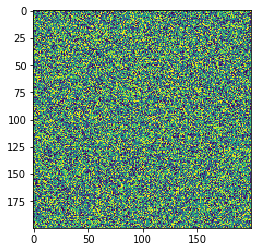


-------------------- iter 100 --------------------


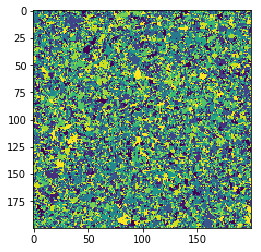


-------------------- iter 200 --------------------


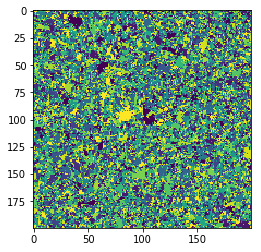


-------------------- iter 300 --------------------


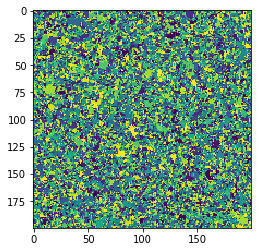


-------------------- iter 400 --------------------


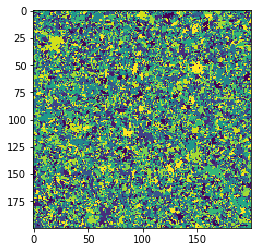


-------------------- iter 500 --------------------


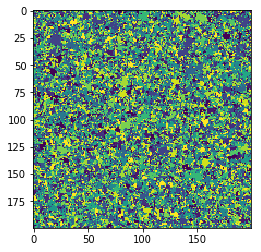


-------------------- iter 600 --------------------


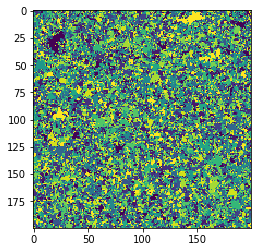


-------------------- iter 700 --------------------


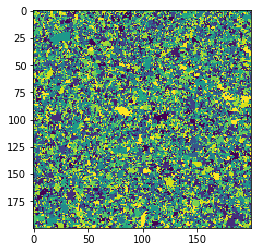


-------------------- iter 800 --------------------


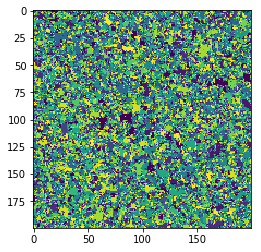


-------------------- iter 900 --------------------


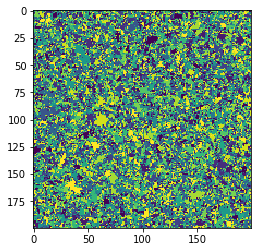


final config:
[[ 8  8  2 ... 13 15 13]
 [ 8 14  6 ...  6 12  6]
 [ 1  1  8 ...  6  8  8]
 ...
 [16 16  9 ...  7 10 13]
 [ 2  2  2 ...  7  8 13]
 [16 16  2 ...  8  8  8]]


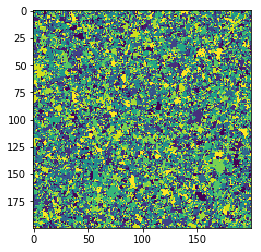

In [84]:
only_averages = False
prt = False
N, no_cols = 200, 16
gamma = 0    # strength of preference for low no. of cols
J = .8        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, iters=1000)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.80601996 0.19398004]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 5 16  7 ...  2  6 14]
 [ 8 11  5 ... 15  8 10]
 [ 3 13 11 ...  3  9 12]
 ...
 [15  9 12 ...  6  1  5]
 [ 2  7  2 ... 12 13  2]
 [11  6  8 ... 10  3 13]]

-------------------- iter 0 --------------------


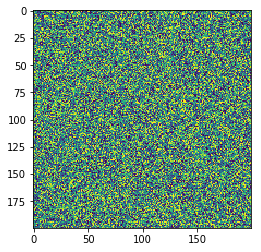


-------------------- iter 100 --------------------


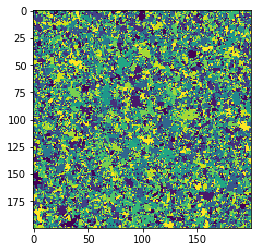


-------------------- iter 200 --------------------


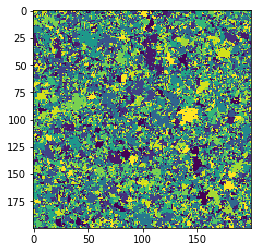


-------------------- iter 300 --------------------


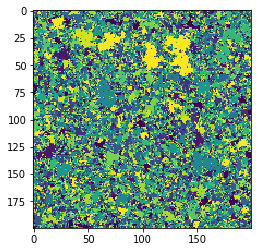


-------------------- iter 400 --------------------


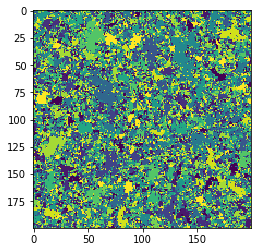


-------------------- iter 500 --------------------


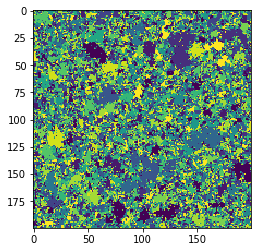


-------------------- iter 600 --------------------


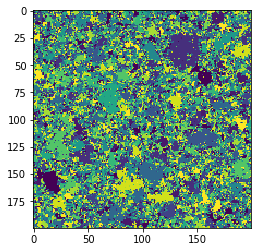


-------------------- iter 700 --------------------


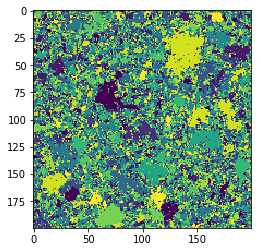


-------------------- iter 800 --------------------


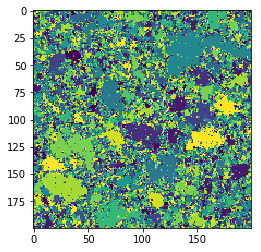


-------------------- iter 900 --------------------


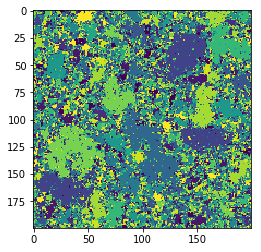


final config:
[[ 7  1  9 ...  9  9  9]
 [11  3  3 ...  9  9 13]
 [15 15 10 ...  9  9  9]
 ...
 [ 6  6  9 ... 13  3  1]
 [14  9  9 ...  2  2  7]
 [13  1  5 ... 12  4  7]]


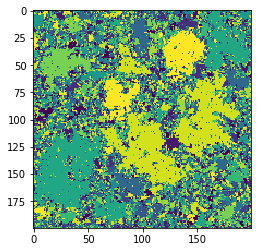

In [88]:
only_averages = False
prt = False
N, no_cols = 200, 16
gamma = 0    # strength of preference for low no. of cols
J = .82        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, iters=1000)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.80986102 0.19013898]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[15 11 16 ...  3 10 11]
 [ 6 11  1 ...  1 16  1]
 [16 11 10 ...  2  3  6]
 ...
 [ 6 16 16 ... 14  2 12]
 [10 13  4 ...  3  6  3]
 [ 8  9  8 ... 16  9 15]]

-------------------- iter 0 --------------------


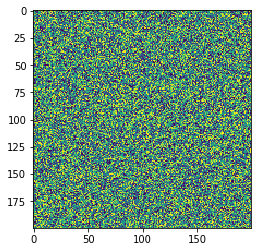


-------------------- iter 100 --------------------


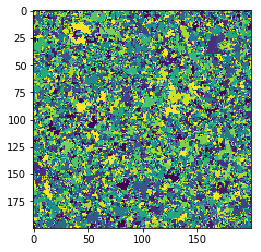


-------------------- iter 200 --------------------


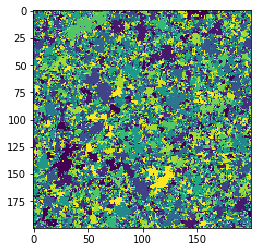


-------------------- iter 300 --------------------


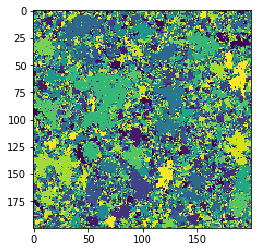


-------------------- iter 400 --------------------


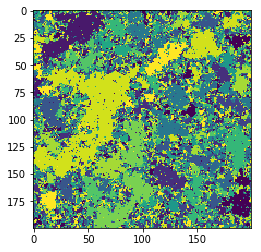


-------------------- iter 500 --------------------


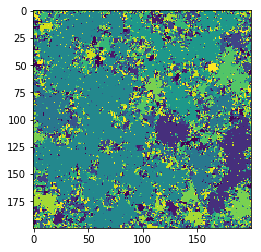


-------------------- iter 600 --------------------


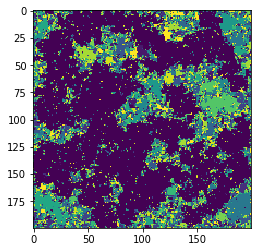


-------------------- iter 700 --------------------


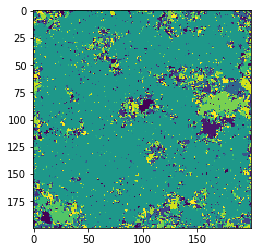


-------------------- iter 800 --------------------


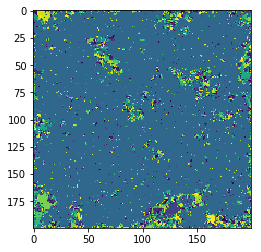


-------------------- iter 900 --------------------


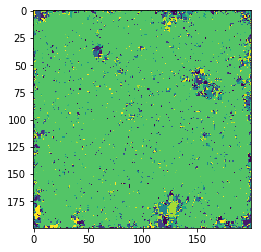


final config:
[[13  5  8 ... 13 16  3]
 [ 3  3  3 ... 10 10 16]
 [ 3  3  3 ... 10 10 10]
 ...
 [ 6  5 15 ... 14 10  7]
 [10  8 16 ... 14  5 14]
 [10  6  6 ... 16  7  7]]


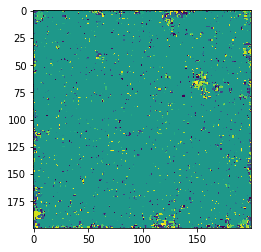

In [89]:
only_averages = False
prt = False
N, no_cols = 200, 16
gamma = 0    # strength of preference for low no. of cols
J = .83        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, iters=1000)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.81731648 0.18268352]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[16  6  3 ...  4 10  3]
 [ 8  4  5 ... 10  6 15]
 [ 6  7  8 ...  6  6  8]
 ...
 [10 16  3 ...  3  6  1]
 [12 13  1 ... 16  2  8]
 [14 13 12 ...  3  4 15]]

-------------------- iter 0 --------------------


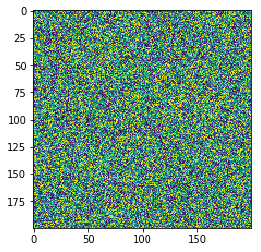


-------------------- iter 100 --------------------


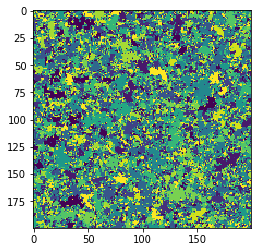


-------------------- iter 200 --------------------


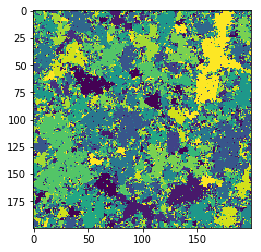


-------------------- iter 300 --------------------


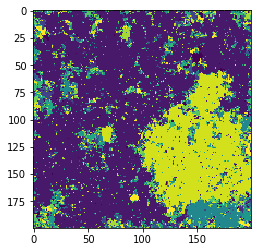


-------------------- iter 400 --------------------


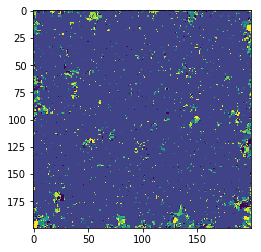

KeyboardInterrupt: 

In [85]:
only_averages = False
prt = False
N, no_cols = 200, 16
gamma = 0    # strength of preference for low no. of cols
J = .85        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, iters=1000)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.83470111 0.16529889]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 5 13  2 ... 16 13 14]
 [ 2  9 16 ...  3  7 16]
 [ 5  6 10 ...  3 14  6]
 ...
 [ 9  3  9 ...  5  4 15]
 [12 13 12 ...  2  7  9]
 [10 13  7 ... 16 12 15]]

-------------------- iter 0 --------------------


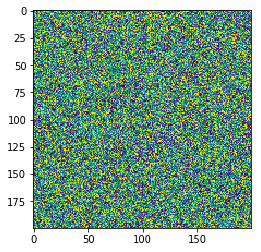


-------------------- iter 100 --------------------


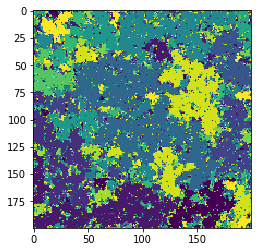


-------------------- iter 200 --------------------


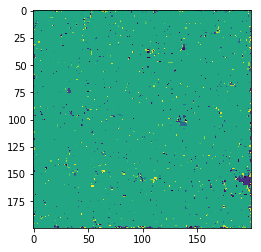


-------------------- iter 300 --------------------


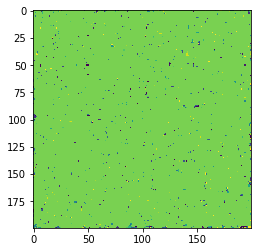

KeyboardInterrupt: 

In [83]:
only_averages = False
prt = False
N, no_cols = 200, 16
gamma = 0    # strength of preference for low no. of cols
J = .9        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, iters=1000)

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.86466472 0.13533528]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 4  2 11 ...  2  7  2]
 [14  6 14 ...  6  1 11]
 [ 1  1 10 ...  4  2 16]
 ...
 [10 15  6 ... 13  1  1]
 [16  5  3 ... 11  7 11]
 [11 14  5 ...  3  2  3]]

-------------------- iter 0 --------------------

-------------------- iter 20 --------------------

-------------------- iter 40 --------------------

-------------------- iter 60 --------------------

-------------------- iter 80 --------------------

-------------------- iter 100 --------------------

-------------------- iter 120 --------------------

-------------------- iter 140 --------------------

-------------------- iter 160 --------------------

-------------------- iter 180 --------------------

-------------------- iter 200 --------------------

-------------------- iter 220 --------------------

-------------------- i

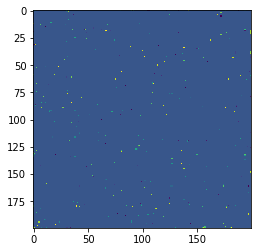

In [72]:
only_averages = False
prt = False
N, no_cols = 200, 16
gamma = 0    # strength of preference for low no. of cols
J = 1        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, iters=1000)